In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from transformers import AutoTokenizer

In [22]:
# Ensure the model is on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# Load and preprocess the dataset
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        paragraphs = f.readlines()
    return [para.strip() for para in paragraphs if len(para.strip()) > 0]

In [24]:
# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Example tokenizer
mask_token = "[MASK]"
if mask_token not in tokenizer.get_vocab():
    tokenizer.add_special_tokens({"mask_token": mask_token}).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [47]:
def tokenize_and_mask(paragraph, mask_token_id, tokenizer):
    tokens = tokenizer(paragraph, return_tensors="pt", padding="max_length", max_length=128, truncation=True).to(device)
    input_ids = tokens["input_ids"].squeeze(0)  # (SeqLen,)
    
    # Masking logic
    num_tokens = input_ids.size(0)
    num_to_mask = max(1, int(0.2 * num_tokens))  # At least 1 token is masked
    mask_indices = random.sample(range(num_tokens), num_to_mask)
    masked_input_ids = input_ids.clone()
    masked_input_ids[mask_indices] = mask_token_id

    return masked_input_ids, input_ids[mask_indices], torch.tensor(mask_indices)

In [27]:
# Transformer Language Model
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, mask_token_id):
        super(TransformerLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.mask_token_id = mask_token_id

        # Define Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, input_ids, masked_indices):
        # Embedding layer
        embeddings = self.embedding(input_ids)  # (Batch, SeqLen, Embed)

        # TransformerEncoder forward pass
        transformer_output = self.transformer_encoder(embeddings)  # (Batch, SeqLen, Embed)

        # Gather outputs corresponding to masked tokens
        masked_outputs = transformer_output[torch.arange(transformer_output.size(0)).unsqueeze(1), masked_indices]  # (Batch, NumMasked, Embed)

        # Project to vocabulary size
        logits = self.fc(masked_outputs)  # (Batch, NumMasked, Vocab)

        return logits

In [48]:
# Loss computation
def compute_loss(logits, target_tokens):
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(logits.view(-1, logits.size(-1)), target_tokens.view(-1))

In [29]:
# Main execution
if __name__ == "__main__":
    # Dataset path
    dataset_path = "/kaggle/input/the-hitchhikers-guide-to-the-galaxy-txt/Hitchhiker Guide to the Galaxy.txt"
    paragraphs = load_dataset(dataset_path)

    # Model parameters
    vocab_size = len(tokenizer.get_vocab())
    embed_dim = 512
    num_heads = 8
    num_layers = 6
    mask_token_id = tokenizer.convert_tokens_to_ids(mask_token)

    # Initialize model
    model = TransformerLM(vocab_size, embed_dim, num_heads, num_layers, mask_token_id).to(device)
    model.train().to(device)

    # Training loop (example for 1 batch)
    batch_size = 4
    batch = random.sample(paragraphs, batch_size)
    
    masked_inputs = []
    target_tokens = []
    mask_indices_list = []

    for paragraph in batch:
        masked_input, target_token, mask_indices = tokenize_and_mask(paragraph, mask_token_id, tokenizer)
        masked_inputs.append(masked_input)
        target_tokens.append(target_token)
        mask_indices_list.append(mask_indices)

    # Convert to tensors
    masked_inputs = torch.stack(masked_inputs)  # (Batch, SeqLen)
    target_tokens = torch.stack(target_tokens)  # (Batch, NumMasked)
    mask_indices_list = torch.stack(mask_indices_list)  # (Batch, NumMasked)

    # Forward pass
    logits = model(masked_inputs, mask_indices_list)

    # Compute loss
    loss = compute_loss(logits, target_tokens)
    print("Loss:", loss.item())

Loss: 10.420313835144043


In [30]:
# Optimizer and training configuration
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [31]:
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0

    for i in range(0, len(paragraphs), batch_size):
        batch = paragraphs[i : i + batch_size]
        
        masked_inputs = []
        target_tokens = []
        mask_indices_list = []

        for paragraph in batch:
            masked_input, target_token, mask_indices = tokenize_and_mask(paragraph, mask_token_id, tokenizer)
            masked_inputs.append(masked_input)
            target_tokens.append(target_token)
            mask_indices_list.append(mask_indices)

        # Convert to tensors
        masked_inputs = torch.stack(masked_inputs).to(device)  # (Batch, SeqLen)
        target_tokens = torch.stack(target_tokens).to(device)  # (Batch, NumMasked)
        mask_indices_list = torch.stack(mask_indices_list).to(device)  # (Batch, NumMasked)

        # Forward pass
        logits = model(masked_inputs, mask_indices_list)

        # Compute loss
        loss = compute_loss(logits, target_tokens)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()
        num_batches += 1

    # Log epoch loss
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/3, Loss: 0.7878
Epoch 2/3, Loss: 0.7022
Epoch 3/3, Loss: 0.6772


In [32]:
# Evaluation
model.eval()
with torch.no_grad():
    example_paragraph = "The Hitchhiker's Guide to the Galaxy is a wholly remarkable book."
    masked_input, _, mask_indices = tokenize_and_mask(example_paragraph, mask_token_id, tokenizer)
    
    masked_input = masked_input.unsqueeze(0).to(device)  # Add batch dimension
    mask_indices = mask_indices.unsqueeze(0).to(device)

    # Forward pass
    logits = model(masked_input, mask_indices)

    # Decode predictions
    predictions = torch.argmax(logits, dim=-1).squeeze(0)  # (NumMasked,)
    predicted_tokens = tokenizer.convert_ids_to_tokens(predictions.tolist())

    print(f"Masked input: {tokenizer.decode(masked_input.squeeze(0).tolist())}")
    print(f"Predicted tokens: {predicted_tokens}")

# Saving the model and tokenizer
torch.save(model.state_dict(), "transformer_lm.pth")
tokenizer.save_pretrained("./tokenizer")

print("Model and tokenizer saved successfully!")

Masked input: [CLS] the hitch [MASK]ker's guide to the galaxy is a wholly remarkable book. [SEP] [PAD] [PAD] [MASK] [PAD] [MASK] [MASK] [MASK] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [MASK] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD]
Predicted tokens: ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [33]:
from sklearn.model_selection import train_test_split

# Load and preprocess data
with open("/kaggle/input/the-hitchhikers-guide-to-the-galaxy-txt/Hitchhiker Guide to the Galaxy.txt", "r") as f:
    text = f.read().splitlines()

# Tokenize data
tokenized_data = [tokenizer.encode(line, add_special_tokens=True) for line in text if len(line.strip()) > 0]

# Split data
train_data, val_test_data = train_test_split(tokenized_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

In [58]:
from torch.utils.data import DataLoader, Dataset

# Dataset class for masked data
class MaskedDataset(Dataset):
    def __init__(self, data, tokenizer, mask_token_id):
        self.data = data
        self.tokenizer = tokenizer
        self.mask_token_id = mask_token_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data[idx]
        # Generate masked tokens
        inputs, labels, mask_indices = tokenize_and_mask(tokens, self.mask_token_id, self.tokenizer)
        return torch.tensor(inputs), torch.tensor(labels), torch.tensor(mask_indices)


# Create Datasets and DataLoaders
train_dataset = MaskedDataset(train_data, tokenizer, mask_token_id=tokenizer.convert_tokens_to_ids("[MASK]"))
val_dataset = MaskedDataset(val_data, tokenizer, mask_token_id=tokenizer.convert_tokens_to_ids("[MASK]"))
test_dataset = MaskedDataset(test_data, tokenizer, mask_token_id)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [49]:
# Main execution
if __name__ == "__main__":
    # Dataset path
    dataset_path = "/kaggle/input/the-hitchhikers-guide-to-the-galaxy-txt/Hitchhiker Guide to the Galaxy.txt"
    paragraphs = load_dataset(dataset_path)

    # Model parameters
    vocab_size = len(tokenizer)  # Total number of tokens in the vocabulary
    embed_dim = 512
    num_heads = 8
    num_layers = 6
    mask_token_id = tokenizer.convert_tokens_to_ids(mask_token)

    # Initialize model
    model = TransformerLM(vocab_size, embed_dim, num_heads, num_layers, mask_token_id).to(device)
    model.train()

    # Training setup
    batch_size = 4
    batch = random.sample(paragraphs, batch_size)
    
    masked_inputs = []
    target_tokens = []
    mask_indices_list = []

    for paragraph in batch:
        masked_input, target_token, mask_indices = tokenize_and_mask(paragraph, mask_token_id, tokenizer)
        masked_inputs.append(masked_input)
        target_tokens.append(target_token)
        mask_indices_list.append(mask_indices)

    # Convert to tensors
    masked_inputs = torch.stack(masked_inputs)  # (Batch, SeqLen)
    target_tokens = torch.stack(target_tokens)  # (Batch, NumMasked)
    mask_indices_list = torch.stack(mask_indices_list)  # (Batch, NumMasked)

    # Forward pass
    logits = model(masked_inputs, mask_indices_list)

    # Compute loss
    loss = compute_loss(logits, target_tokens)
    print("Loss:", loss.item())

    # Optimizer
    learning_rate = 1e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 3
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        for i in range(0, len(paragraphs), batch_size):
            batch = paragraphs[i : i + batch_size]
            
            masked_inputs = []
            target_tokens = []
            mask_indices_list = []

            for paragraph in batch:
                masked_input, target_token, mask_indices = tokenize_and_mask(paragraph, mask_token_id, tokenizer)
                masked_inputs.append(masked_input)
                target_tokens.append(target_token)
                mask_indices_list.append(mask_indices)

            # Convert to tensors
            masked_inputs = torch.stack(masked_inputs).to(device)  # (Batch, SeqLen)
            target_tokens = torch.stack(target_tokens).to(device)  # (Batch, NumMasked)
            mask_indices_list = torch.stack(mask_indices_list).to(device)  # (Batch, NumMasked)

            # Forward pass
            logits = model(masked_inputs, mask_indices_list)

            # Compute loss
            loss = compute_loss(logits, target_tokens)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            total_loss += loss.item()
            num_batches += 1

        # Log epoch loss
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Loss: 10.832205772399902
Epoch 1/3, Loss: 0.7853
Epoch 2/3, Loss: 0.6867
Epoch 3/3, Loss: 0.6953


In [51]:
# Main execution
if __name__ == "__main__":
    # Dataset path
    dataset_path = "/kaggle/input/the-hitchhikers-guide-to-the-galaxy-txt/Hitchhiker Guide to the Galaxy.txt"
    paragraphs = load_dataset(dataset_path)

    # Model parameters
    vocab_size = len(tokenizer)  # Total number of tokens in the vocabulary
    embed_dim = 512
    num_heads = 8
    num_layers = 6
    mask_token_id = tokenizer.convert_tokens_to_ids(mask_token)

    # Initialize model
    model = TransformerLM(vocab_size, embed_dim, num_heads, num_layers, mask_token_id).to(device)
    model.train()

    # Training setup
    batch_size = 4
    batch = random.sample(paragraphs, batch_size)
    
    masked_inputs = []
    target_tokens = []
    mask_indices_list = []

    for paragraph in batch:
        masked_input, target_token, mask_indices = tokenize_and_mask(paragraph, mask_token_id, tokenizer)
        masked_inputs.append(masked_input)
        target_tokens.append(target_token)
        mask_indices_list.append(mask_indices)

    # Convert to tensors
    masked_inputs = torch.stack(masked_inputs)  # (Batch, SeqLen)
    target_tokens = torch.stack(target_tokens)  # (Batch, NumMasked)
    mask_indices_list = torch.stack(mask_indices_list)  # (Batch, NumMasked)

    # Forward pass
    logits = model(masked_inputs, mask_indices_list)

    # Compute loss
    loss = compute_loss(logits, target_tokens)
    print("Loss:", loss.item())

    # Optimizer
    learning_rate = 1e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        for i in range(0, len(paragraphs), batch_size):
            batch = paragraphs[i : i + batch_size]
            
            masked_inputs = []
            target_tokens = []
            mask_indices_list = []

            for paragraph in batch:
                masked_input, target_token, mask_indices = tokenize_and_mask(paragraph, mask_token_id, tokenizer)
                masked_inputs.append(masked_input)
                target_tokens.append(target_token)
                mask_indices_list.append(mask_indices)

            # Convert to tensors
            masked_inputs = torch.stack(masked_inputs).to(device)  # (Batch, SeqLen)
            target_tokens = torch.stack(target_tokens).to(device)  # (Batch, NumMasked)
            mask_indices_list = torch.stack(mask_indices_list).to(device)  # (Batch, NumMasked)

            # Forward pass
            logits = model(masked_inputs, mask_indices_list)

            # Compute loss
            loss = compute_loss(logits, target_tokens)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            total_loss += loss.item()
            num_batches += 1

        # Log epoch loss
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        example_paragraph = "The Hitchhiker's Guide to the Galaxy is a wholly remarkable book."
        masked_input, _, mask_indices = tokenize_and_mask(example_paragraph, mask_token_id, tokenizer)
        
        masked_input = masked_input.unsqueeze(0).to(device)  # Add batch dimension
        mask_indices = mask_indices.unsqueeze(0).to(device)

        # Forward pass
        logits = model(masked_input, mask_indices)

        # Decode predictions
        predictions = torch.argmax(logits, dim=-1).squeeze(0)  # (NumMasked,)
        predicted_tokens = tokenizer.convert_ids_to_tokens(predictions.tolist())

        print(f"Masked input: {tokenizer.decode(masked_input.squeeze(0).tolist())}")
        print(f"Predicted tokens: {predicted_tokens}")

    # Saving the model and tokenizer
    torch.save(model.state_dict(), "transformer_lm.pth")
    tokenizer.save_pretrained("./tokenizer")

    print("Model and tokenizer saved successfully!")

    # Preparing dataset for training
    with open("/kaggle/input/the-hitchhikers-guide-to-the-galaxy-txt/Hitchhiker Guide to the Galaxy.txt", "r") as f:
        text = f.read().splitlines()

    # Tokenize data
    tokenized_data = [tokenizer.encode(line, add_special_tokens=True) for line in text if len(line.strip()) > 0]

    # Split data
    train_data, val_test_data = train_test_split(tokenized_data, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

    # Create Datasets and DataLoaders
    train_dataset = MaskedDataset(train_data, tokenizer, mask_token_id=tokenizer.convert_tokens_to_ids("[MASK]"))
    val_dataset = MaskedDataset(val_data, tokenizer, mask_token_id=tokenizer.convert_tokens_to_ids("[MASK]"))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Parameters for the TransformerLM model
    model = TransformerLM(vocab_size, embed_dim=128, num_heads=4, num_layers=4, mask_token_id=tokenizer.convert_tokens_to_ids("[MASK]")).to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

Loss: 10.323634147644043
Epoch 1/10, Loss: 0.7879
Epoch 2/10, Loss: 0.6986
Epoch 3/10, Loss: 0.6819
Epoch 4/10, Loss: 0.6701
Epoch 5/10, Loss: 0.6669
Epoch 6/10, Loss: 0.6640
Epoch 7/10, Loss: 0.6614
Epoch 8/10, Loss: 0.6550
Epoch 9/10, Loss: 0.6429
Epoch 10/10, Loss: 0.6559
Masked input: [CLS] the [MASK]hiker [MASK] s guide to [MASK] galaxy [MASK] a wholly remarkable [MASK]. [SEP] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [MASK] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [MASK] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [P

TypeError: train_model() got an unexpected keyword argument 'device'

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
# List to store the loss values for visualization
epoch_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0

    for i in range(0, len(paragraphs), batch_size):
        batch = paragraphs[i : i + batch_size]
        
        masked_inputs = []
        target_tokens = []
        mask_indices_list = []

        for paragraph in batch:
            masked_input, target_token, mask_indices = tokenize_and_mask(paragraph, mask_token_id, tokenizer)
            masked_inputs.append(masked_input)
            target_tokens.append(target_token)
            mask_indices_list.append(mask_indices)

        # Convert to tensors
        masked_inputs = torch.stack(masked_inputs).to(device)  # (Batch, SeqLen)
        target_tokens = torch.stack(target_tokens).to(device)  # (Batch, NumMasked)
        mask_indices_list = torch.stack(mask_indices_list).to(device)  # (Batch, NumMasked)

        # Forward pass
        logits = model(masked_inputs, mask_indices_list)

        # Compute loss
        loss = compute_loss(logits, target_tokens)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()
        num_batches += 1

    # Log epoch loss
    avg_loss = total_loss / num_batches
    epoch_losses.append(avg_loss)  # Store the loss for visualization
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 0.6926
Epoch 2/100, Loss: 0.6779
Epoch 3/100, Loss: 0.6689
Epoch 4/100, Loss: 0.6689
Epoch 5/100, Loss: 0.6618
Epoch 6/100, Loss: 0.6497
Epoch 7/100, Loss: 0.6453
Epoch 8/100, Loss: 0.6475
Epoch 9/100, Loss: 0.6415
Epoch 10/100, Loss: 0.6363
Epoch 11/100, Loss: 0.6377
Epoch 12/100, Loss: 0.6300
Epoch 13/100, Loss: 0.6369
Epoch 14/100, Loss: 0.6338
Epoch 15/100, Loss: 0.6252
Epoch 16/100, Loss: 0.6317
Epoch 17/100, Loss: 0.6288
Epoch 18/100, Loss: 0.6301
Epoch 19/100, Loss: 0.6216
Epoch 20/100, Loss: 0.6169
Epoch 21/100, Loss: 0.6187
Epoch 22/100, Loss: 0.6139
Epoch 23/100, Loss: 0.6195
Epoch 24/100, Loss: 0.6198
Epoch 25/100, Loss: 0.6187
Epoch 26/100, Loss: 0.6224
Epoch 27/100, Loss: 0.6221
Epoch 28/100, Loss: 0.6135
Epoch 29/100, Loss: 0.6175
Epoch 30/100, Loss: 0.5997
Epoch 31/100, Loss: 0.6199
Epoch 32/100, Loss: 0.6184
Epoch 33/100, Loss: 0.6070
Epoch 34/100, Loss: 0.6069
Epoch 35/100, Loss: 0.6178
Epoch 36/100, Loss: 0.6152
Epoch 37/100, Loss: 0.6094
Epoch 38/1

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


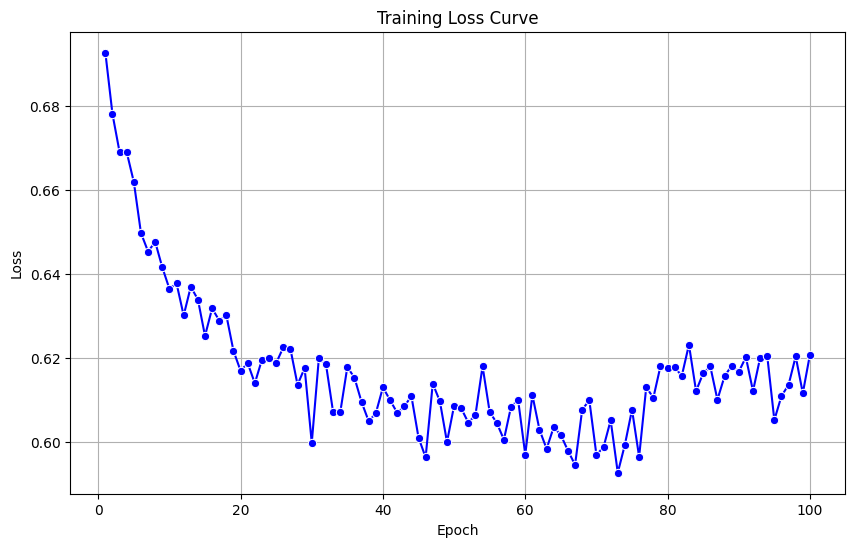

In [71]:
# Plot training loss curve
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=epoch_losses, marker='o', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Masked input: [CLS] the hitchhiker's guide to [MASK] galaxy [MASK] a [MASK] remarkable book. [SEP] [PAD] [MASK] [MASK] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [MASK] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD] [PAD] [MASK] [PAD] [MASK] [PAD] [PAD] [PAD] [PAD]
Predicted tokens: ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

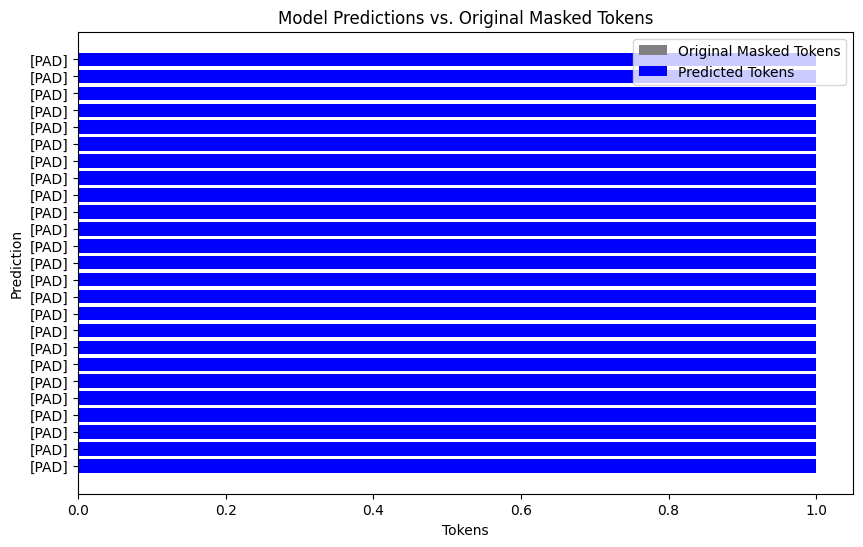

In [72]:
# Example for visualization
model.eval()
with torch.no_grad():
    example_paragraph = "The Hitchhiker's Guide to the Galaxy is a wholly remarkable book."
    masked_input, _, mask_indices = tokenize_and_mask(example_paragraph, mask_token_id, tokenizer)
    
    masked_input = masked_input.unsqueeze(0).to(device)  # Add batch dimension
    mask_indices = mask_indices.unsqueeze(0).to(device)

    # Forward pass
    logits = model(masked_input, mask_indices)

    # Decode predictions
    predictions = torch.argmax(logits, dim=-1).squeeze(0)  # (NumMasked,)
    predicted_tokens = tokenizer.convert_ids_to_tokens(predictions.tolist())
    
    # Get original tokens (without masking)
    original_tokens = tokenizer.tokenize(example_paragraph)

    # Visualize predictions vs original (before masking)
    masked_input_text = tokenizer.decode(masked_input.squeeze(0).tolist())
    print(f"Masked input: {masked_input_text}")
    print(f"Predicted tokens: {predicted_tokens}")

    # Plotting the original vs predicted tokens (for visualization)
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(predicted_tokens)), [1] * len(predicted_tokens), color='gray', label='Original Masked Tokens')
    plt.barh(range(len(predicted_tokens)), [1] * len(predicted_tokens), color='blue', label='Predicted Tokens')
    plt.yticks(range(len(predicted_tokens)), predicted_tokens)
    plt.xlabel('Tokens')
    plt.ylabel('Prediction')
    plt.title('Model Predictions vs. Original Masked Tokens')
    plt.legend(loc='best')
    plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


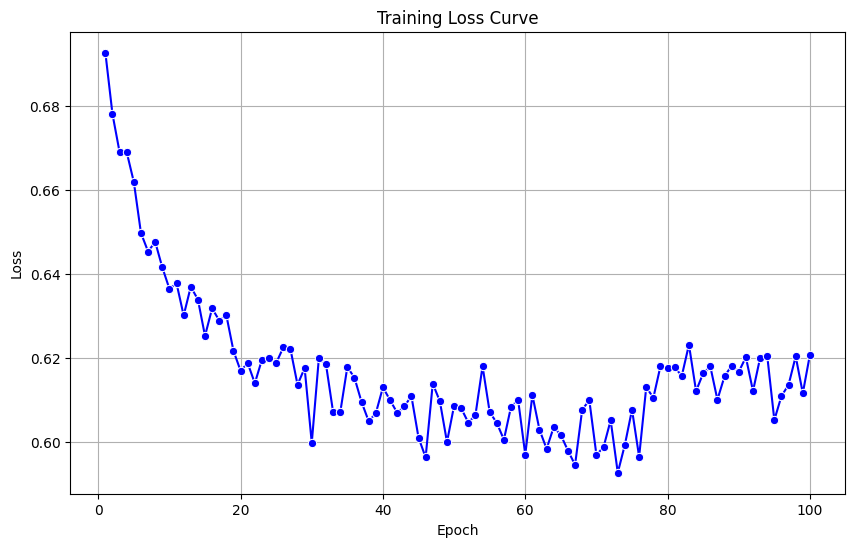

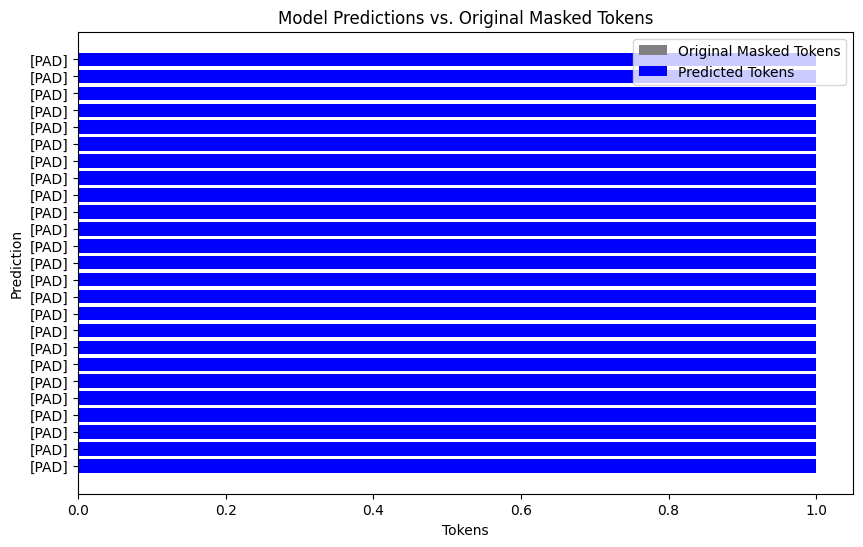

In [73]:
# Save the loss plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=epoch_losses, marker='o', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('training_loss_curve.png')

# Save the model predictions plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(predicted_tokens)), [1] * len(predicted_tokens), color='gray', label='Original Masked Tokens')
plt.barh(range(len(predicted_tokens)), [1] * len(predicted_tokens), color='blue', label='Predicted Tokens')
plt.yticks(range(len(predicted_tokens)), predicted_tokens)
plt.xlabel('Tokens')
plt.ylabel('Prediction')
plt.title('Model Predictions vs. Original Masked Tokens')
plt.legend(loc='best')
plt.savefig('model_predictions.png')
